In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import pywt
import cv2

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from keras import optimizers

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from keras import optimizers
import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unziping the dataset

!unzip -q "/content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/Dataset.zip"

In [ ]:
def wavelet_transform(image):
    image = cv2.resize(image,(image.shape[0]*2,image.shape[1]*2))
    coeff_f = []
    for i in range(image.shape[-1]):
        c1,(c2,c3,c4) = pywt.dwt2(image[:,:,i], wavelet = 'db3', mode = 'periodization')
        coeff_f.append(c1)
        coeff_f.append(c2)
        coeff_f.append(c3)
        # coeff_f.append(c4)
        return np.moveaxis(np.array(coeff_f),0,-1)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                         
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function = wavelet_transform)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                   preprocessing_function = wavelet_transform)

test_datagen  = ImageDataGenerator(rescale = 1./255,
                                   preprocessing_function = wavelet_transform)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/Brain Image Analysis/Dataset/archive/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/Brain Image Analysis/Dataset/archive/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/My Drive/Brain Image Analysis/Dataset/archive/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 4106 images belonging to 4 classes.
Found 1025 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


In [ ]:
# input_mri_image = Input(batch_shape = (16,224,224,12))
# n1 = Conv2D(filters = 12, kernel_size = (4,4), padding = 'same', activation = 'relu')(input_mri_image)
# n2 = Conv2D(filters = 6, kernel_size = (4,4), padding = 'same', activation = 'relu')(n1)
# n3 = Conv2D(filters = 3, kernel_size = (4,4), padding = 'same', activation = 'relu')(n2)

# pre_model = Model(inputs = [input_mri_image], outputs = [n3])

# base_model = DenseNet121( input_shape=(224,224,3),
#                    include_top=False,
#                    weights="imagenet")

# def get_densenet():
#   densenet_model = DenseNet121(
#                    include_top=False,
#                    weights="imagenet")
#   for layer in densenet_model.layers:
#     layer.trainable=False
#   return densenet_model

# def get_pre_model():

#   input_mri_image = Input(batch_shape = (16,224,224,12))
#   n1 = Conv2D(filters = 12, kernel_size = (3,3), padding = 'same', activation = 'relu')(input_mri_image)
#   n2 = Conv2D(filters = 6, kernel_size = (3,3), padding = 'same', activation = 'relu')(n1)
#   n3 = Conv2D(filters = 3, kernel_size = (3,3), padding = 'same', activation = 'relu')(n2)

#   pre_model = Model(inputs = input_mri_image, outputs = n1)
#   return pre_model

# def get_post_model():

#   model=Sequential()
#   # model.add(pre_model)
#   # model.add(base_model)
#   model.add(Dropout(0.5))
#   model.add(Flatten())
#   model.add(BatchNormalization())
#   model.add(Dense(64,kernel_initializer='he_uniform'))
#   model.add(BatchNormalization())
#   model.add(Activation('relu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(64,kernel_initializer='he_uniform'))
#   model.add(BatchNormalization())
#   model.add(Activation('relu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(64,kernel_initializer='he_uniform'))
#   model.add(BatchNormalization())
#   model.add(Activation('relu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(32,kernel_initializer='he_uniform'))
#   model.add(BatchNormalization())
#   model.add(Activation('relu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(32,kernel_initializer='he_uniform'))
#   model.add(BatchNormalization())
#   model.add(Activation('relu'))
#   model.add(Dense(4,activation='softmax'))

#   return model

# def get_model():
#   pre_model = get_pre_model()
#   densenet_model = get_densenet()
#   post_model = get_post_model()

#   input_mri_image = Input(batch_shape=(16,224,224,12))

#   pre_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)
#   densenet_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)
#   post_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

#   wavelet_feature_images = pre_model(input_mri_image)
#   result_densenet = densenet_model(wavelet_feature_images)
#   output_result = post_model(result_densenet)

#   model = Model(inputs=input_mri_image, outputs = output_result)
#   model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

#   return model, pre_model


# model, pre_model = get_model()

In [ ]:
# input_mri_image = Input(batch_shape = (16,224,224,12))
# n1 = Conv2D(filters = 12, kernel_size = (4,4), padding = 'same', activation = 'relu')(input_mri_image)
# n2 = Conv2D(filters = 6, kernel_size = (4,4), padding = 'same', activation = 'relu')(n1)
# n3 = Conv2D(filters = 3, kernel_size = (4,4), padding = 'same', activation = 'relu')(n2)

# pre_model = Model(inputs = [input_mri_image], outputs = [n3])

base_model = ResNet50( input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

for layer in base_model.layers:
    layer.trainable=False

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

model.build((None,224,224,3))

In [ ]:
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6422592   
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
activation_5 (Activation)    (None, 64)               

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val 

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
weights_file=os.path.join("/content/drive/MyDrive/Brain Image Analysis/model_resnet_wavelet.hdf5")
 
checkpoint = ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

callbacks= [checkpoint, lr_scheduler]

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,
                  validation_data=valid_dataset,
                  epochs = 100,
                  verbose = 1,
                  callbacks=callbacks) 

Epoch 1/100
129/129 [==============================] - 100s 728ms/step - loss: 1.0106 - accuracy: 0.7754 - precision: 0.6587 - recall: 0.2108 - auc: 0.7990 - f1_score: 0.3127 - val_loss: 0.9999 - val_accuracy: 0.7780 - val_precision: 0.8912 - val_recall: 0.1278 - val_auc: 0.7993 - val_f1_score: 0.2438

Epoch 00001: val_accuracy improved from -inf to 0.77805, saving model to /content/drive/MyDrive/Brain Image Analysis/model_resnet_wavelet.hdf5
Epoch 2/100
129/129 [==============================] - 93s 717ms/step - loss: 1.0018 - accuracy: 0.7782 - precision: 0.6659 - recall: 0.2263 - auc: 0.8030 - f1_score: 0.3361 - val_loss: 1.0052 - val_accuracy: 0.7807 - val_precision: 0.8539 - val_recall: 0.1483 - val_auc: 0.8118 - val_f1_score: 0.2414

Epoch 00002: val_accuracy improved from 0.77805 to 0.78073, saving model to /content/drive/MyDrive/Brain Image Analysis/model_resnet_wavelet.hdf5
Epoch 3/100
129/129 [==============================] - 92s 709ms/step - loss: 0.9964 - accuracy: 0.7767 

In [ ]:
model.save_weights("/content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/model_densenet_wavelet.hdf5")

NameError: ignored

In [ ]:
model.load_weights("/content/drive/MyDrive/Brain Image Analysis/model_resnet_wavelet.hdf5")

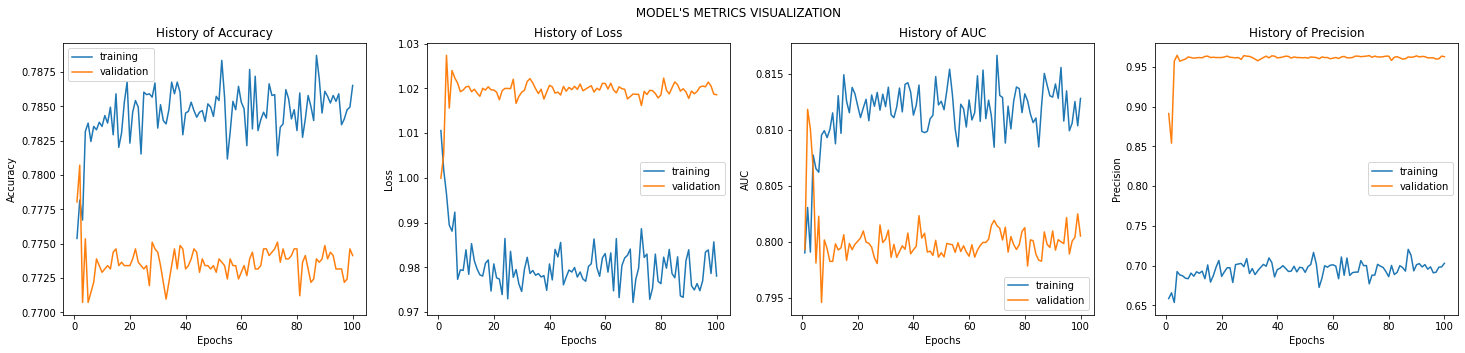

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (25,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
  
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
              )

In [ ]:
scores = model.evaluate(test_dataset)

41/41 [==============================] - 252s 6s/step - loss: 0.9443 - accuracy: 0.7955 - precision: 0.7495 - recall: 0.2732 - auc: 0.8226 - f1_score: 0.3860


In [ ]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])

Accuracy =  0.795472264289856
Precision =  0.7494646906852722
Recall =  0.2732240557670593
AUC =  0.8225963115692139
